## 写在前头

本来`geopandas`安装已经非常麻烦了，但是后面画图，要是用`cartopy`，这两个包还安装冲突。
因此如果你在安装`cartopy`后，发现`geopandas`的一些函数有问题，建议这么做：
1. 使用conda安装`cartopy`: `conda install cartopy`;
2. 再使用pip安装`geopandas`: `pip install geopandas`.

## 导入包

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import geopandas as gpd
from netCDF4 import num2date
import datetime

from tqdm import tqdm

tqdm.pandas()
from shapely.geometry import Point

import matplotlib.pyplot as plt

import platform

from cartopy import crs as ccrs

if platform.system() == 'Darwin':
    plt.rcParams["font.family"] = 'Arial Unicode MS'
elif platform.system() == 'Windows':
    plt.rcParams["font.family"] = 'SimHei'
else:
    pass

## 加载nc文件和读取数据


In [2]:
nc_data = nc.Dataset("cru_ts4.05.1901.2020.tmp.dat.nc")

In [3]:
for temp_value in nc_data.variables.values():
    print("*" * 70)
    print(temp_value)

**********************************************************************
<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    long_name: longitude
    units: degrees_east
unlimited dimensions: 
current shape = (720,)
filling on, default _FillValue of 9.969209968386869e+36 used
**********************************************************************
<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    long_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used
**********************************************************************
<class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    long_name: time
    units: days since 1900-1-1
    calendar: gregorian
unlimited dimensions: time
current shape = (1440,)
filling on, default _FillValue of 9.969209968386869e+36 used
**********************************************************************
<class 'netCDF4._netCDF4.Variable'>
float32 tmp(time, la

<ipython-input-3-ab2ee6009efa>:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(temp_value)


## 提取变量


In [4]:
raw_lat_data = np.array(nc_data.variables['lat'])
raw_lon_data = np.array(nc_data.variables['lon'])
raw_time_data = np.array(nc_data.variables['time'])
raw_tmp_data = np.array(nc_data.variables['tmp'])


<ipython-input-4-c2593932da71>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_lat_data = np.array(nc_data.variables['lat'])
<ipython-input-4-c2593932da71>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_lon_data = np.array(nc_data.variables['lon'])
<ipython-input-4-c2593932da71>:3: DeprecationWarning: `np.bool` is a deprecated alias for 

In [5]:
raw_tmp_data.shape


(1440, 360, 720)

### 对时间处理

In [6]:
def cftime2datetime(cftime, units, format='%Y-%m-%d %H:%M:%S'):
    """
    将nc文件里面的时间格式 从cftime 转换到 datetime格式
    :param cftime:
    :param units:
    :param format:
    :return:
    """
    return datetime.datetime.strptime(num2date(times=cftime, units=units).strftime(format), format)


clean_time_data = [cftime2datetime(i, units='days since 1900-1-1') for i in raw_time_data]
clean_time_data[:4]

[datetime.datetime(1901, 1, 16, 0, 0),
 datetime.datetime(1901, 2, 15, 0, 0),
 datetime.datetime(1901, 3, 16, 0, 0),
 datetime.datetime(1901, 4, 16, 0, 0)]

## 计算全球每年的平均气温

In [7]:
avg_mean_tmp = np.ones(shape=raw_tmp_data.shape[0])

for index in tqdm(range(raw_tmp_data.shape[0])):
    temp_temp = raw_tmp_data[index, :, :]
    avg_mean_tmp[index] = temp_temp[temp_temp != 9.96921e+36].mean()

100%|██████████| 1440/1440 [00:00<00:00, 2243.31it/s]


In [8]:
avg_mean_tmp_df = pd.DataFrame({'date': clean_time_data,
                                'avg_mean_tmp': avg_mean_tmp})
avg_mean_tmp_df['year'] = avg_mean_tmp_df['date'].dt.year
avg_mean_tmp_df['month'] = avg_mean_tmp_df['date'].dt.month
avg_mean_tmp_df


,date,avg_mean_tmp,year,month
0,1901-01-16,-2.276233,1901,1
1,1901-02-15,-0.606501,1901,2
2,1901-03-16,3.036036,1901,3
3,1901-04-16,7.728032,1901,4
4,1901-05-16,12.336249,1901,5
...,...,...,...,...
1435,2020-08-16,17.980717,2020,8
1436,2020-09-16,15.052033,2020,9
1437,2020-10-16,10.223289,2020,10
1438,2020-11-16,5.359230,2020,11


In [9]:
year_tmp_df = avg_mean_tmp_df.groupby(['year']).agg(
    avg_tmp=('avg_mean_tmp', 'mean')
).reset_index()
year_tmp_df.head()

,year,avg_tmp
0,1901,8.029477
1,1902,7.642335
2,1903,7.813257
3,1904,7.759539
4,1905,7.875768


In [10]:
% matplotlib inline

In [11]:
def smooth_data(y_value, deg=4):
    x_new = np.arange(y_value.shape[0])
    new_param = np.polyfit(x_new, y_value, deg=deg)
    value = np.zeros_like(x_new)
    for index, param in enumerate(new_param[::-1]):
        value = value + param * x_new ** index
    return value


y_new = smooth_data(y_value=year_tmp_df['avg_tmp'])


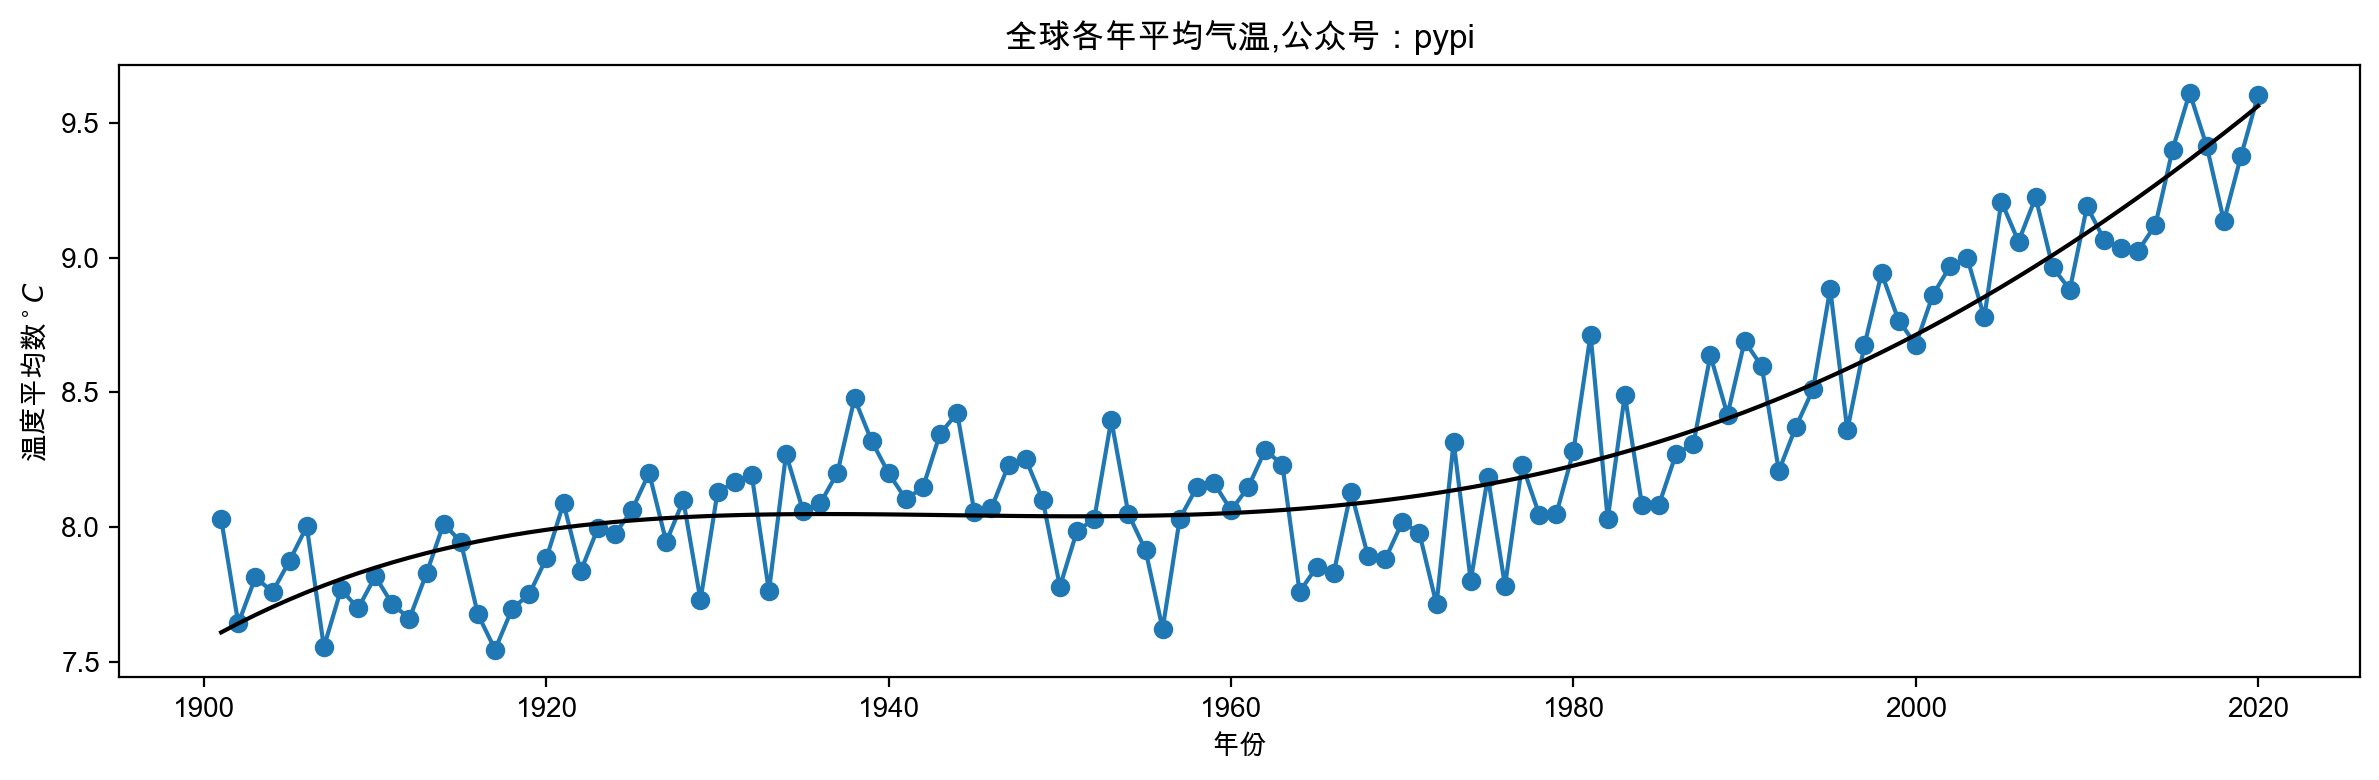

In [12]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)
# 原始点
ax.plot(year_tmp_df['year'], year_tmp_df['avg_tmp'], linestyle='-', marker='o')
# 多项式拟合
ax.plot(year_tmp_df['year'], y_new, linestyle='-', color='black')
ax.set_title("全球各年平均气温,公众号：pypi")
ax.set_xlabel("年份")
ax.set_ylabel("温度平均数$ ^\circ C $")
plt.tight_layout()
plt.show()
fig.savefig("结果/全球各年平均气温.png")


## 导入中国边界数据

In [16]:
china_boundary = gpd.read_file(filename="数据集/中国地图边界202111版.json")

china_boundary_valid = china_boundary.copy()
china_boundary_valid['geometry'] = china_boundary.buffer(0)

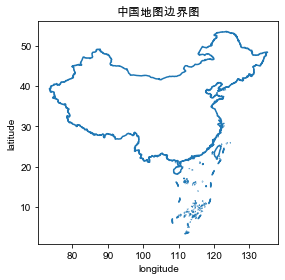

In [17]:
fig, ax = plt.subplots()
china_boundary.boundary.plot(ax=ax)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title("中国地图边界图")
plt.tight_layout()

### 对比一下两个地图

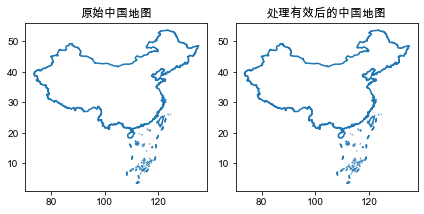

In [18]:
fig, ax = plt.subplots(ncols=2)
china_boundary.boundary.plot(ax=ax[0])
china_boundary_valid.boundary.plot(ax=ax[1])
ax[0].set_title("原始中国地图")
ax[1].set_title("处理有效后的中国地图")
plt.tight_layout()


In [19]:
def pic(lon, lat) -> bool:
    """
    检测一个点是否在中国边界线内
    lon:东经
    lat:北纬
    :param lon:
    :param lat:
    :return:
    """
    return china_boundary_valid.contains(Point(lon, lat))[0]


pic(lon=116, lat=45)

Lon_data, Lat_data = np.meshgrid(raw_lon_data, raw_lat_data)

point_set_df = pd.DataFrame({'longitude': Lon_data.flatten(),
                             'latitude': Lat_data.flatten(),
                             'tmp_300': raw_tmp_data[300, :, :].flatten()})

point_set_df.loc[point_set_df['tmp_300'] == np.max(raw_tmp_data), ['tmp_300']] = np.nan

In [20]:
clean_time_data[300]

datetime.datetime(1926, 1, 16, 0, 0)

In [21]:
# 检测每一个点是否在中国内

point_set_df['in_china'] = point_set_df.progress_apply(lambda x: pic(lon=x['longitude'], lat=x['latitude']), axis=1)
point_set_df.head()

100%|██████████| 259200/259200 [01:05<00:00, 3980.04it/s] 


,longitude,latitude,tmp_300,in_china
0,-179.75,-89.75,NaN,False
1,-179.25,-89.75,NaN,False
2,-178.75,-89.75,NaN,False
3,-178.25,-89.75,NaN,False
4,-177.75,-89.75,NaN,False


In [22]:
min(point_set_df['tmp_300']), max(point_set_df['tmp_300'])

(nan, nan)

## 可视化1(基础)

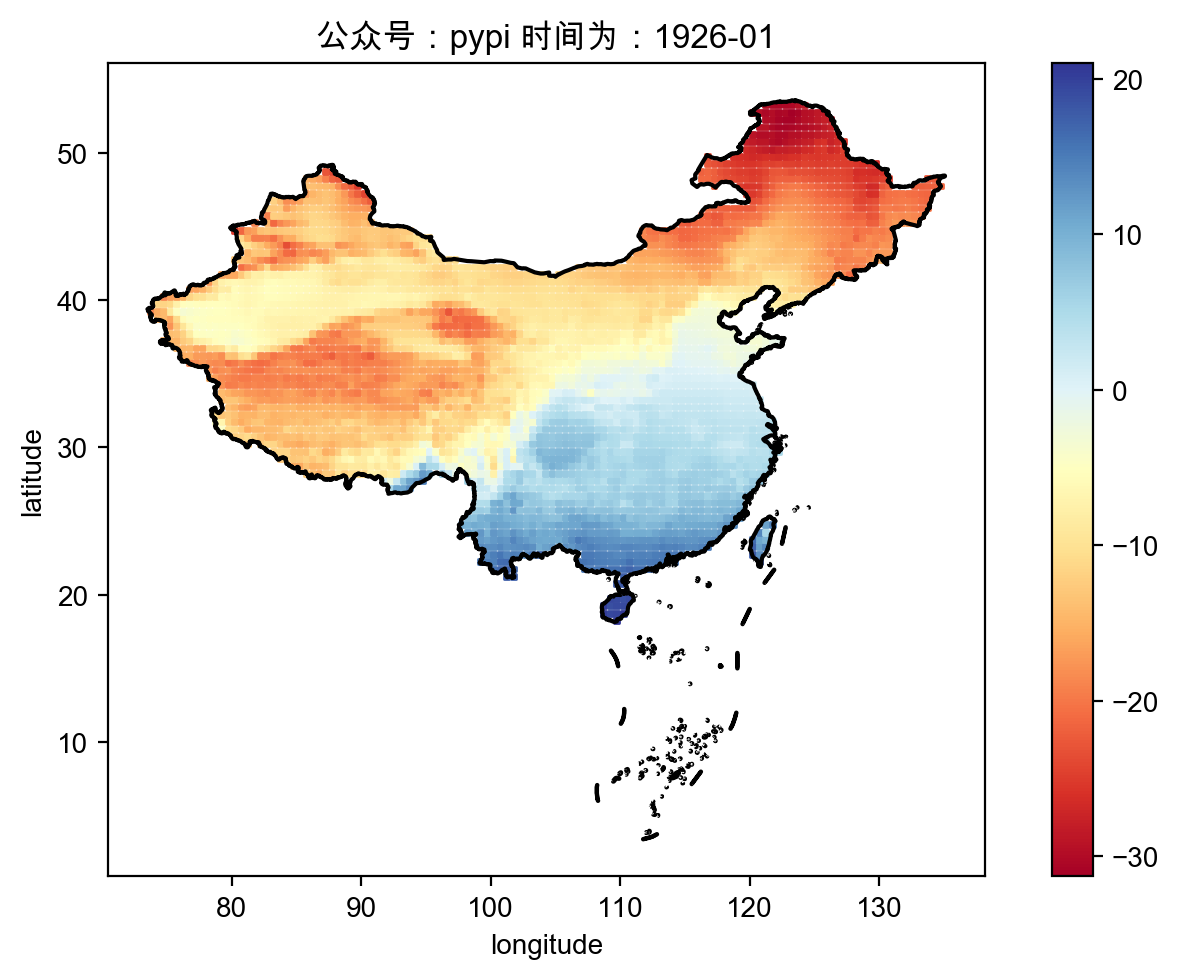

In [23]:
point_in_ch = point_set_df.loc[point_set_df['in_china']]

fig, ax = plt.subplots(figsize=(7, 5), dpi=200)
china_boundary.boundary.plot(ax=ax, color='black')
colorbar = ax.scatter(point_in_ch['longitude'], point_in_ch['latitude'],
                      c=point_in_ch['tmp_300'], s=3,
                      marker='s',
                      cmap=plt.cm.get_cmap('RdYlBu'))
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title(f"公众号：pypi 时间为：{clean_time_data[300]:%Y-%m}")
plt.tight_layout()
fig.colorbar(colorbar, ax=ax)

fig.savefig("检测点是否在中国境内.png")

## 可视化2(兰伯特投影)



In [24]:
china_center_x, china_center_y = china_boundary['geometry'].centroid.x, china_boundary['geometry'].centroid.y

<ipython-input-24-f277b5316483>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  china_center_x, china_center_y = china_boundary['geometry'].centroid.x, china_boundary['geometry'].centroid.y
<ipython-input-24-f277b5316483>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  china_center_x, china_center_y = china_boundary['geometry'].centroid.x, china_boundary['geometry'].centroid.y


In [25]:
crs_epsg = ccrs.LambertConformal(central_longitude=china_center_x[0], central_latitude=china_center_y[0])
china_boundary_ccrs = china_boundary.copy()
china_boundary_ccrs = china_boundary_ccrs.to_crs(crs_epsg.proj4_init)
# china_boundary_ccrs['geometry'].set_crs({'init': 'epsg:3875'},allow_override=True)
china_boundary_ccrs.crs


<Projected CRS: +proj=lcc +ellps=WGS84 +lon_0=103.8742889900012 +l ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
point_in_ch = point_set_df.loc[point_set_df['in_china']]

In [27]:
china_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
crs_epsg.proj4_init

'+ellps=WGS84 +proj=lcc +lon_0=103.8742889900012 +lat_0=36.42375089735982 +x_0=0.0 +y_0=0.0 +lat_1=33 +lat_2=45 +no_defs'

In [29]:
gpd_point_in_ch = gpd.GeoDataFrame(
    point_in_ch,
    geometry=gpd.points_from_xy(x=point_in_ch['longitude'], y=point_in_ch['latitude']),
    crs=china_boundary.crs
)
gpd_point_in_ch = gpd_point_in_ch.to_crs(crs_epsg.proj4_init)
gpd_point_in_ch

,longitude,latitude,tmp_300,in_china,geometry
138816,108.25,6.25,NaN,True,POINT (559727.940 -3501754.583)
140988,114.25,7.75,NaN,True,POINT (1303151.820 -3250214.180)
144588,114.25,10.25,NaN,True,POINT (1267582.939 -2940044.387)
153223,111.75,16.25,NaN,True,POINT (900246.991 -2247898.931)
156099,109.75,18.25,21.000000,True,POINT (656788.731 -2030169.810)
...,...,...,...,...,...
206524,122.25,53.25,-30.300001,True,POINT (1252555.828 2003950.741)
206525,122.75,53.25,-30.300001,True,POINT (1286152.735 2010934.895)
206526,123.25,53.25,-30.100000,True,POINT (1319710.706 2018103.797)
206527,123.75,53.25,-29.300001,True,POINT (1353228.725 2025457.229)


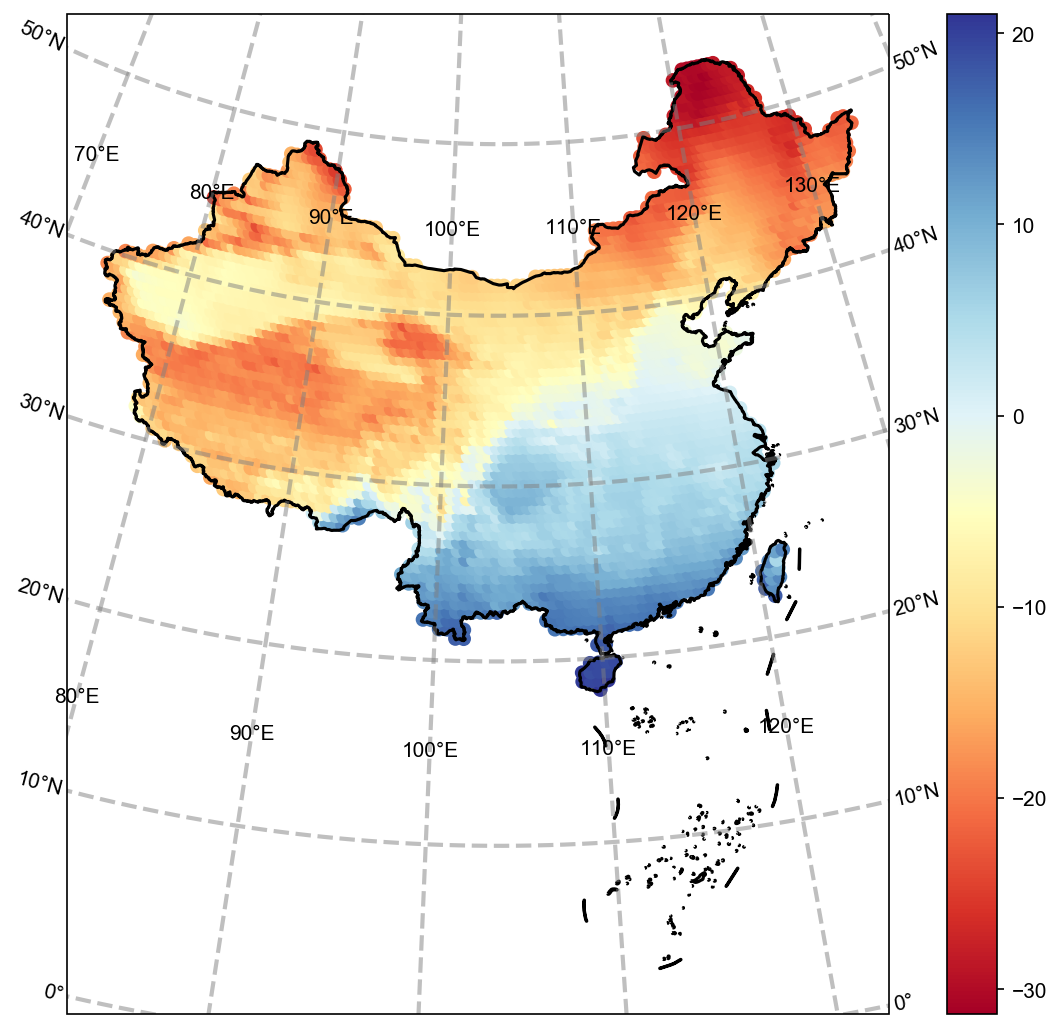

In [30]:
fig, ax = plt.subplots(figsize=(8, 7), dpi=150, subplot_kw={'projection': crs_epsg})
ax.gridlines(draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')
china_boundary_ccrs.boundary.plot(ax=ax, color='black', marker='s')
gpd_point_in_ch.plot(ax=ax, column='tmp_300', cmap=plt.cm.get_cmap('RdYlBu'), legend=True)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
# ax.set_title(f"公众号：pypi 时间为：{clean_time_data[300]:%Y-%m}")
plt.tight_layout()

fig.savefig("检测点是否在中国境内_Lambert.png")

## 中国地图边界裁剪

In [31]:
china_boundary_box = china_boundary_valid.bounds.iloc[0]

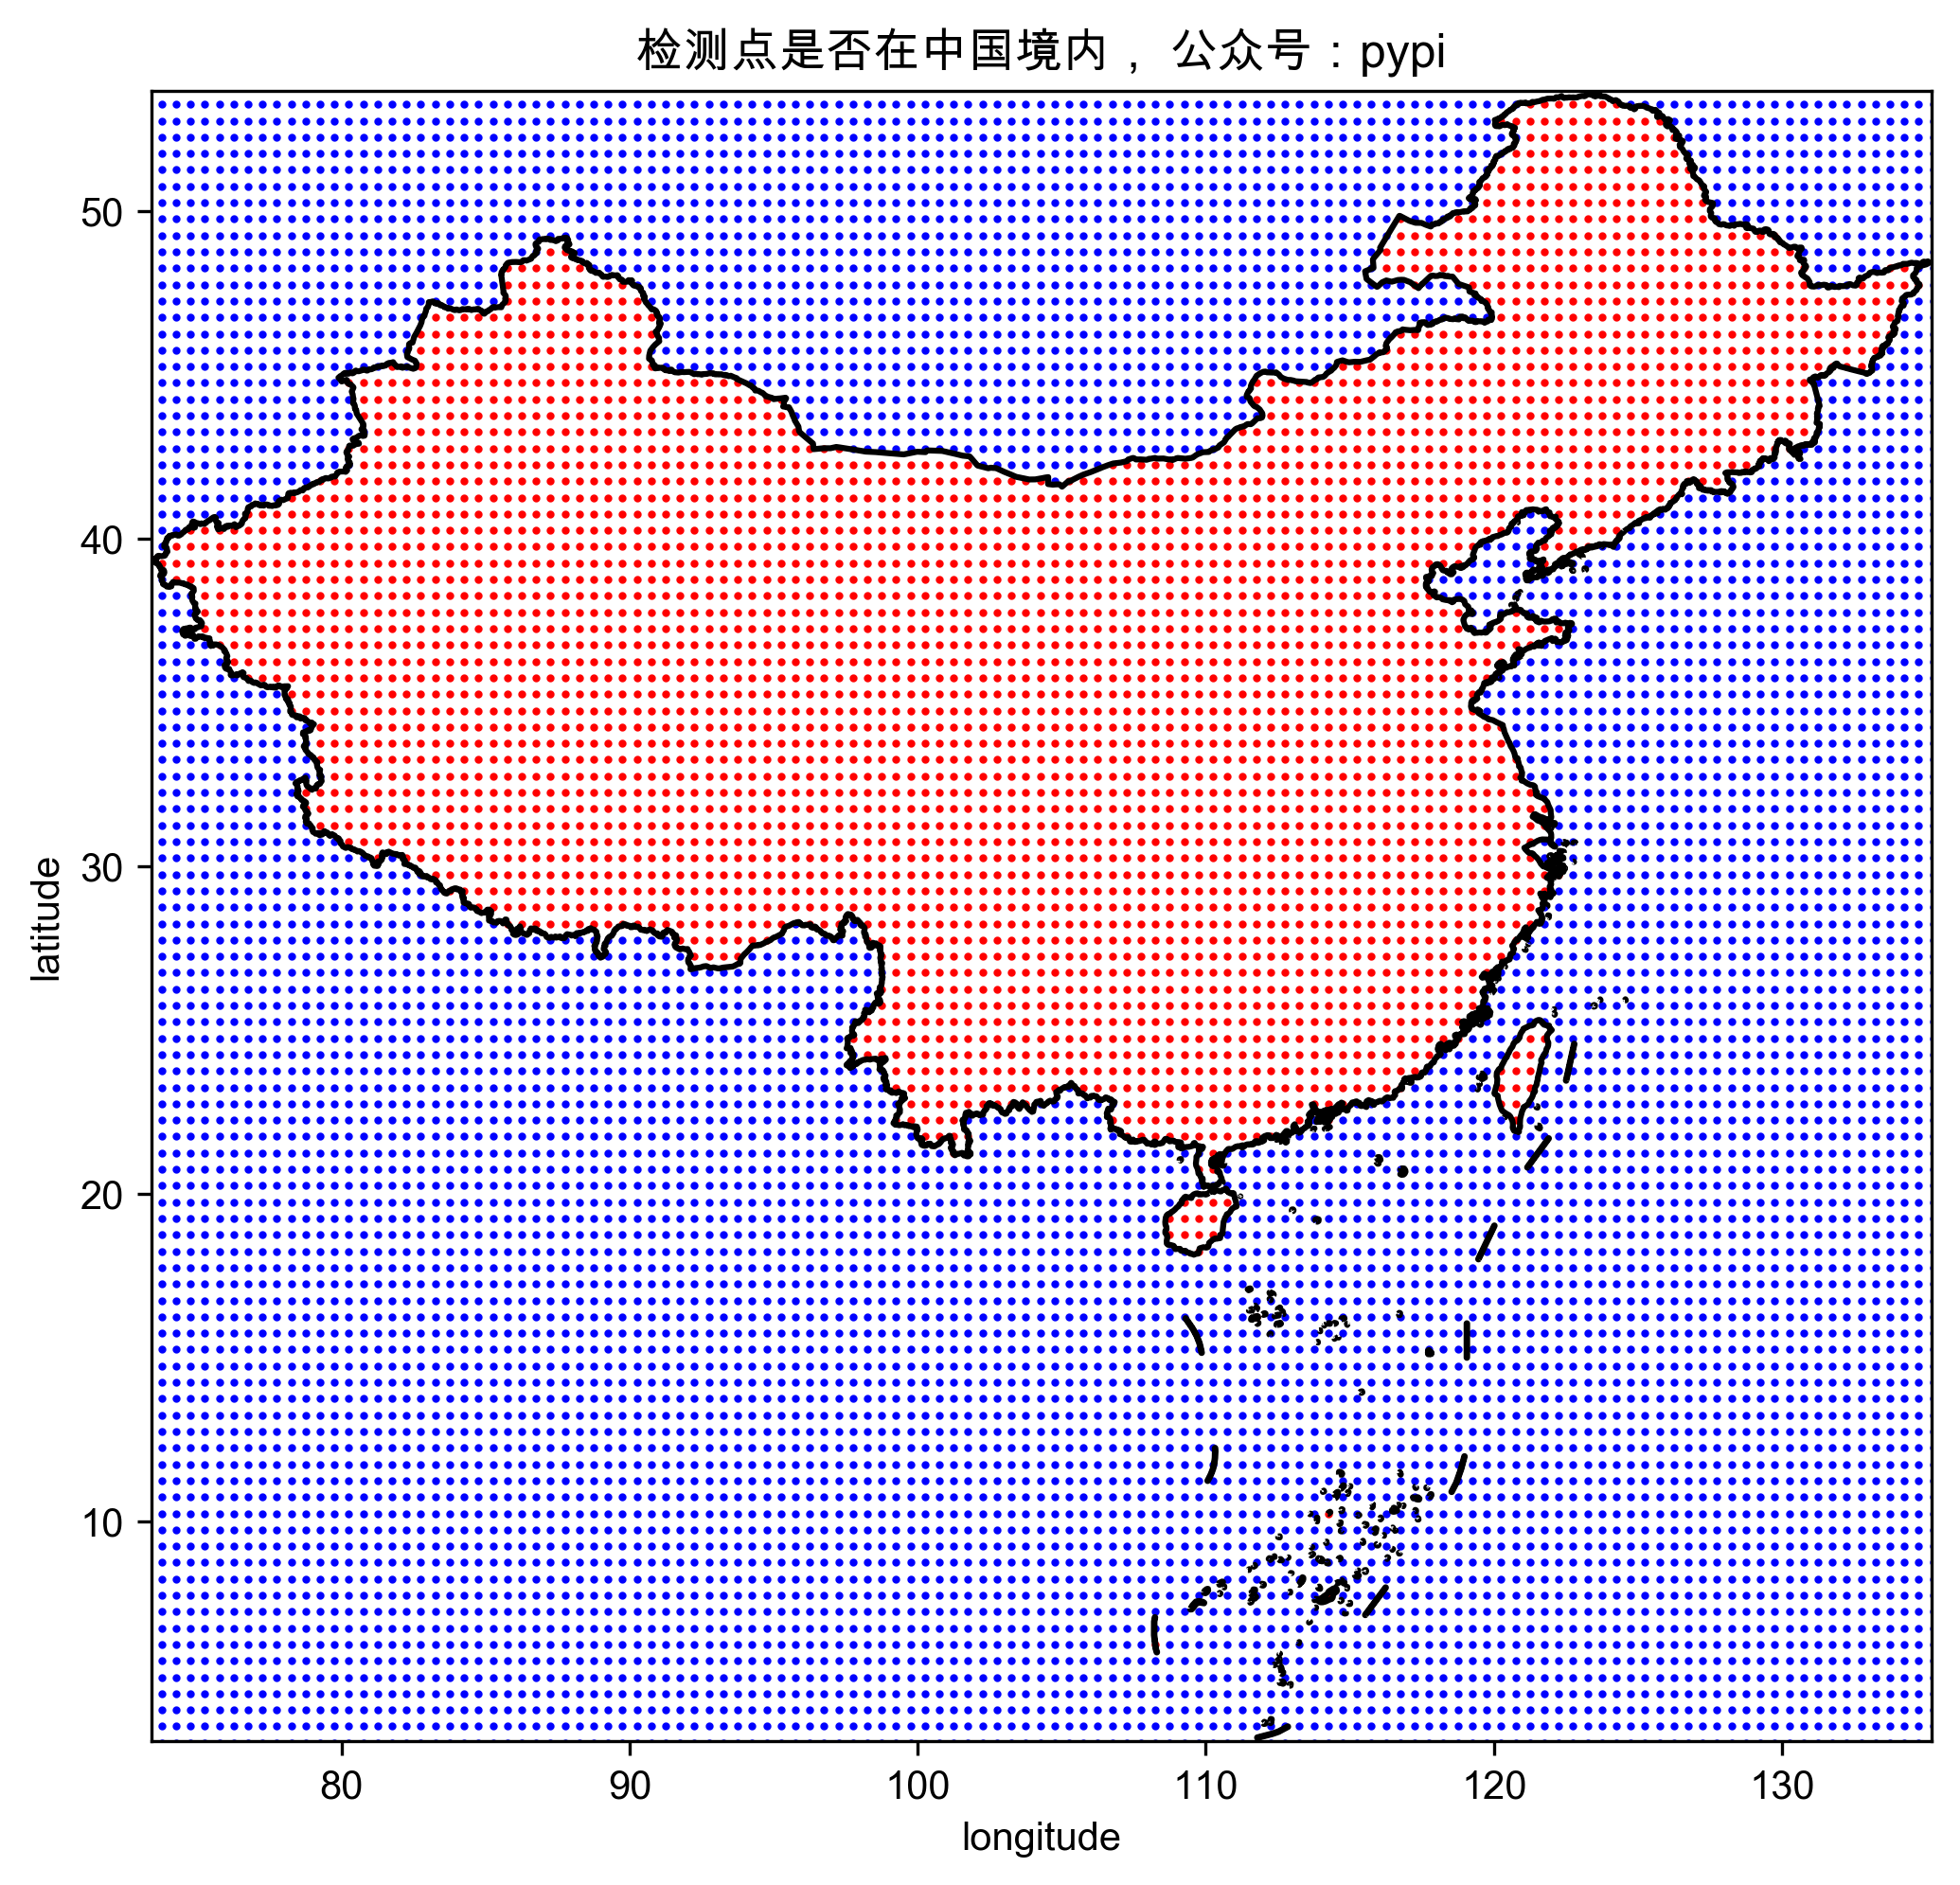

In [32]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
china_boundary.boundary.plot(ax=ax, color='black')
# 在中国内的点
point_in_ch = point_set_df.loc[point_set_df['in_china']]
ax.scatter(point_in_ch['longitude'], point_in_ch['latitude'], c='red', s=1)

# 不在中国内的点
point_notin_ch = point_set_df.loc[~point_set_df['in_china']]
ax.scatter(point_notin_ch['longitude'], point_notin_ch['latitude'], c='blue', s=1)

ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title("检测点是否在中国境内， 公众号：pypi")
ax.set_xlim(china_boundary_box.minx - 0.1, china_boundary_box.maxx + 0.1)
ax.set_ylim(china_boundary_box.miny - 0.1, china_boundary_box.maxy + 0.1)
plt.tight_layout()
fig.savefig("检测点是否在中国境内2.png")


# 高阶部分
## 计算每一年的平均温度 并且输出tiff文件

In [58]:
temp_data = raw_tmp_data[pd.Series(clean_time_data).dt.year == 1902, :, :]

(dim, lon, lat) = temp_data.shape


(12, 360, 720)

In [179]:
missing_value = nc_data.variables['tmp'].missing_value


def cal_year_avg(year):
    """
    :param year:
    :return:
    """
    temp_data = raw_tmp_data[pd.Series(clean_time_data).dt.year == year, :, :]

    out = temp_data.copy()
    out[out == missing_value] = np.nan

    if len(temp_data.shape) == 3:

        out = np.nanmean(out, axis=0)
        return out
    else:

        return out

In [180]:
out = cal_year_avg(year=2001)[::-1, :]

100%|██████████| 360/360 [00:01<00:00, 334.58it/s]


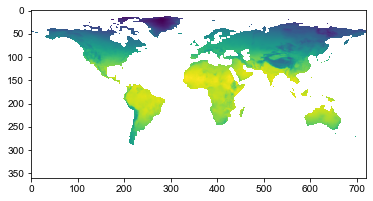

In [181]:
fig, ax = plt.subplots()
ax.imshow(out)


## 保存tiff文件

/opt/anaconda3/envs/devc/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,
/opt/anaconda3/envs/devc/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


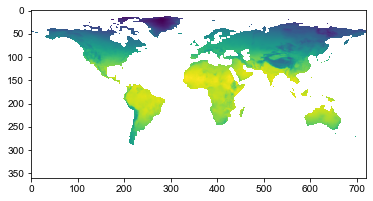

In [182]:
import rasterio
from rasterio.transform import from_origin

arr = out

new_dataset = rasterio.open('结果/year_1902.tiff', 'w', driver='GTiff',
                            height=arr.shape[0], width=arr.shape[1],
                            count=1, dtype=str(arr.dtype),
                            )

new_dataset.write(arr, 1)
new_dataset.close()

fig, ax = plt.subplots()
src = rasterio.open('结果/year_1902.tiff')
ax.imshow(src.read(1))

In [ ]:
# 将matrix保存为tiff文件
#
# from PIL import Image
#
# tif = Image.fromarray(out, mode='F')
# tif.save('结果/test1901.tiff', 'TIFF')

In [196]:
# 批量保存

def patch_save_tiff(year):
    out = cal_year_avg(year=year)[::-1, :]

    tiff_filename = f"结果/year_{year}.tiff"
    new_dataset = rasterio.open(tiff_filename, 'w', driver='GTiff',
                                height=out.shape[0], width=out.shape[1],
                                count=1, dtype=str(out.dtype),
                                )
    new_dataset.write(out, 1)
    new_dataset.close()


from joblib import Parallel, delayed


In [197]:
np.max(pd.Series(clean_time_data).dt.year), np.min(pd.Series(clean_time_data).dt.year)

(2020, 1901)

In [198]:
_ = Parallel(n_jobs=12, verbose=4)(delayed(patch_save_tiff)(year=year) for year in range(1901, 2021))

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:   23.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:   32.0s finished


## 计算一定时间范围内的气温平均值

In [183]:

def cal_daterange(start_date, end_date):
    """

    :param start_date: 开始时间
    :param end_date: 结束时间
    :param empty_value: 设置输出的默认填充缺失值
    :return: 返回的时间段是[start_date, end_date] ,统计的是均值
    """
    temp_data = raw_tmp_data[(start_date <= pd.Series(clean_time_data)) & (pd.Series(clean_time_data) <= end_date), :,
                :]
    out = temp_data.copy()
    out[out == missing_value] = np.nan

    if len(temp_data.shape) == 3:

        out = np.nanmean(out, axis=0)
        return out
    else:

        return out


out = cal_daterange(start_date='1901-10', end_date='1902-01')


100%|██████████| 360/360 [00:01<00:00, 340.07it/s]


In [191]:
data = np.arange(12).reshape(3, 4)
data


array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [193]:
mask = np.random.choice(a=[True, False], size=(3, 4))

In [195]:
np.where(mask)

(array([0, 1, 1, 1, 2, 2]), array([1, 0, 2, 3, 1, 2]))

In [202]:
import rasterio

out = np.random.randint(low=10, high=20, size=(360, 720)).astype('float64')
new_dataset = rasterio.open('test.tiff', 'w', driver='GTiff',
                            height=out.shape[0], width=out.shape[1],
                            count=1, dtype=str(out.dtype),
                            )
new_dataset.write(out, 1)
new_dataset.close()

/opt/anaconda3/envs/devc/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,
